## Imports

In [1]:
import sys
import os
from PIL import Image, ImageDraw
import pathlib
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append(pathlib.Path(os.getcwd(), 'facenet_pytorch').as_posix())

In [3]:
from facenet_pytorch import MTCNN, extract_face, InceptionResnetV1, fixed_image_standardization
from utils import resize, rotate_image, pad_image, resize_bounding_boxes

## Recognition

### Annotating faces on an image

In [31]:
mtcnn = MTCNN(
    # margin=14,
    keep_all=True,
    # factor=0.5,
    device='cuda:0',
    thresholds=[0.6, 0.7, 0.9]
).eval()

resnet = InceptionResnetV1(
    # pretrained="vggface2", 
    pretrained="casia-webface",
    device='cuda:0'
).eval()

MAX_WIDTH = 500
MAX_HEIGHT = 500

In [57]:
impath_both = 'assets/me_viji.jpg'
# impath_both = 'assets/me_viji_2.JPG'
# impath_both = 'assets/hard_me_viji.JPG'
impath_me = 'assets/me.png'
# impath_me = 'assets/me_2.jpeg'
# impath_me = 'assets/lenna.png'
# impath_me = 'assets/viji.jpg'

In [58]:
image_both_big = Image.open(impath_both)
ratio_both, image_both = resize(image_both_big, MAX_HEIGHT, MAX_WIDTH)
image_both = pad_image(image_both, MAX_WIDTH, MAX_HEIGHT)
with torch.no_grad():
    faces_both, probs_both = mtcnn.detect(image_both)

torch.Size([3, 160, 160])
torch.Size([3, 160, 160])


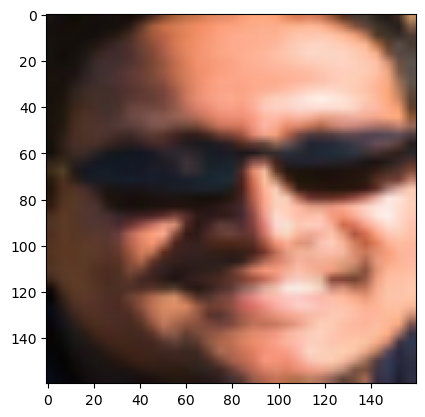

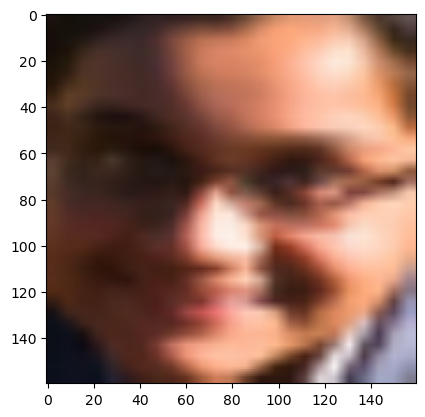

<Figure size 640x480 with 0 Axes>

In [61]:
for (left, top, right, bottom) in faces_both:
    face = extract_face(image_both, (left, top, right, bottom))
    print(face.shape)
    plt.imshow(face.permute(1, 2, 0).int().numpy())
    plt.figure()

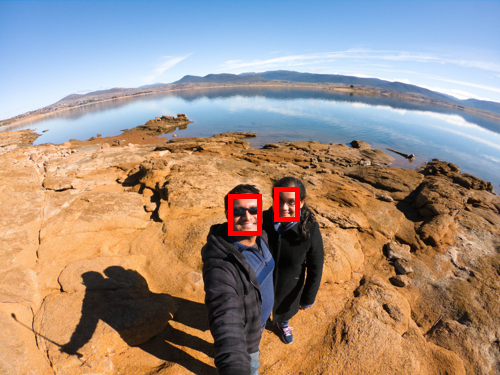

In [62]:
image_both_cp = Image.open(impath_both)
ratio_both_cp, image_both_cp = resize(image_both_cp, MAX_HEIGHT, MAX_WIDTH)
image_both = pad_image(image_both, MAX_WIDTH, MAX_HEIGHT)
imagebb_both = ImageDraw.Draw(image_both_cp)

for (left, top, right, bottom) in faces_both:
    imagebb_both = ImageDraw.Draw(image_both_cp) 
    shape = [left, top, right, bottom]
    imagebb_both.rectangle(shape, outline="red", width=5)
display(image_both_cp)

In [63]:
faces_both

array([[228.2154 , 194.53429, 261.5479 , 235.27026],
       [274.68784, 187.55946, 299.32285, 221.0145 ]], dtype=float32)

In [64]:
image_me_big = Image.open(impath_me).convert('RGB')
ratio_me, image_me = resize(image_me_big, MAX_HEIGHT, MAX_WIDTH)
image_me = pad_image(image_me, MAX_WIDTH, MAX_HEIGHT)
faces_me, probs_me = mtcnn.detect(image_me)

torch.Size([3, 160, 160])


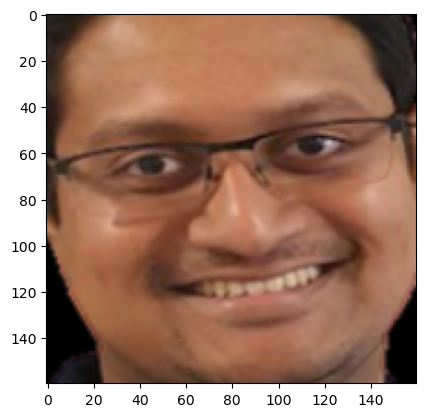

<Figure size 640x480 with 0 Axes>

In [65]:
for (left, top, right, bottom) in faces_me:
    face = extract_face(image_me, (left, top, right, bottom))
    print(face.shape)
    plt.imshow(face.permute(1, 2, 0).int().numpy())
    plt.figure()

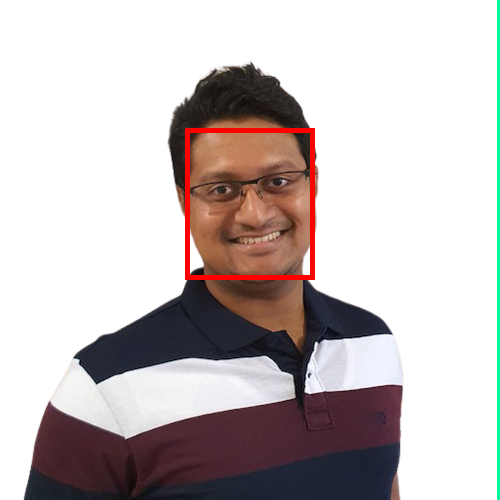

In [66]:
image_me_cp = Image.open(impath_me)
ratio_me_cp, image_me_cp = resize(image_me_cp, MAX_HEIGHT, MAX_WIDTH)
image_me_cp = pad_image(image_me_cp, MAX_WIDTH, MAX_HEIGHT)
imagebb_me = ImageDraw.Draw(image_me)


for (left, top, right, bottom) in faces_me:
    imagebb_me = ImageDraw.Draw(image_me_cp) 
    shape = [left, top, right, bottom]
    imagebb_me.rectangle(shape, outline="red", width=5)
display(image_me_cp)

### Using encodings of one face, searching for that image on another

In [67]:
def compare_mtcnn_detects(img):
    with torch.no_grad():
        faces = mtcnn(img)
        boxes, probs = mtcnn.detect(img)
        faces2 = mtcnn.extract(img, boxes, None)
    
    return faces.eq(faces2).all()

In [68]:
compare_mtcnn_detects(image_me).item()

True

In [69]:
compare_mtcnn_detects(image_both)

tensor(True)

In [70]:
def get_boxes(img):
    with torch.no_grad():
        boxes, probs = mtcnn.detect(img)
    return boxes

def get_faces(img, boxes):
    with torch.no_grad():
        faces = mtcnn.extract(img, boxes, None)
    return faces
    
def get_encodings(faces):
    with torch.no_grad():
        faces = faces.to('cuda:0')
        return resnet(faces).cpu()
    
def dist(enc1, enc2):
    return np.sum(np.square(enc1.numpy() - enc2.numpy()), 1)

Me
	 [186.22423 129.09277 314.967   279.59363]
Both
	 [ 912.8616   778.13715 1046.1917   941.08105]
	 [1098.7513   750.23785 1197.2914   884.058  ]
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])
torch.Size([3, 160, 160])


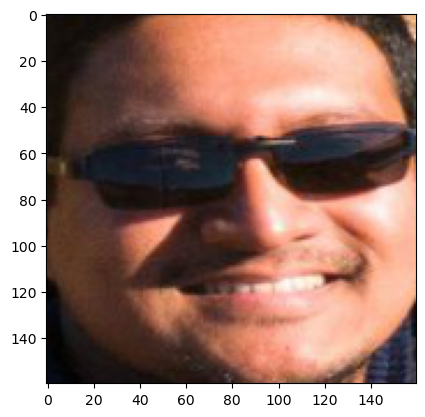

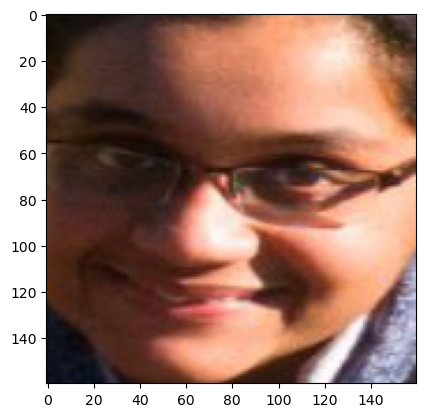

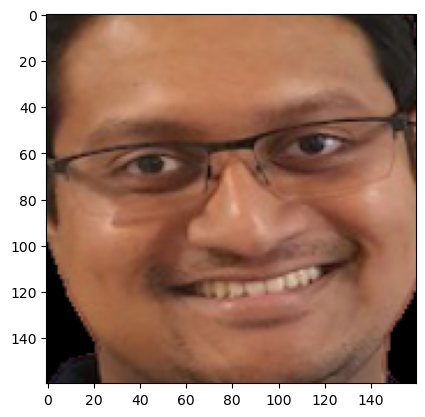

<Figure size 640x480 with 0 Axes>

In [71]:
me_boxes = get_boxes(image_me)
both_boxes = get_boxes(image_both)

me_faces = get_faces(image_me, me_boxes)
both_faces = get_faces(image_both, both_boxes)

me_boxes_big = me_boxes/ratio_me
me_faces_big = get_faces(image_me_big, me_boxes_big)

both_boxes_big = both_boxes/ratio_both
both_faces_big = get_faces(image_both_big, both_boxes_big)

    
print('Me')
for b in me_boxes_big:
    print('\t', b)
print('Both')
for b in both_boxes_big:
    print('\t', b)

for (left, top, right, bottom) in both_boxes_big:
    face = extract_face(image_both_big, (left, top, right, bottom))
    print(face.shape)
    plt.imshow(face.permute(1, 2, 0).int().numpy())
    plt.figure()
    

for (left, top, right, bottom) in me_boxes_big:
    face = extract_face(image_me_big, (left, top, right, bottom))
    print(face.shape)
    plt.imshow(face.permute(1, 2, 0).int().numpy())
    plt.figure()

In [72]:
me_faces.shape, both_faces.shape

(torch.Size([1, 3, 160, 160]), torch.Size([2, 3, 160, 160]))

In [73]:
me_enc = get_encodings(me_faces_big)
both_enc = get_encodings(both_faces_big)

distances = dist(me_enc, both_enc)
distances, max(distances) - min(distances)

(array([0.498133  , 0.93183684], dtype=float32), 0.43370384)

In [74]:
is_me_flags = [x==min(distances) for x in distances]

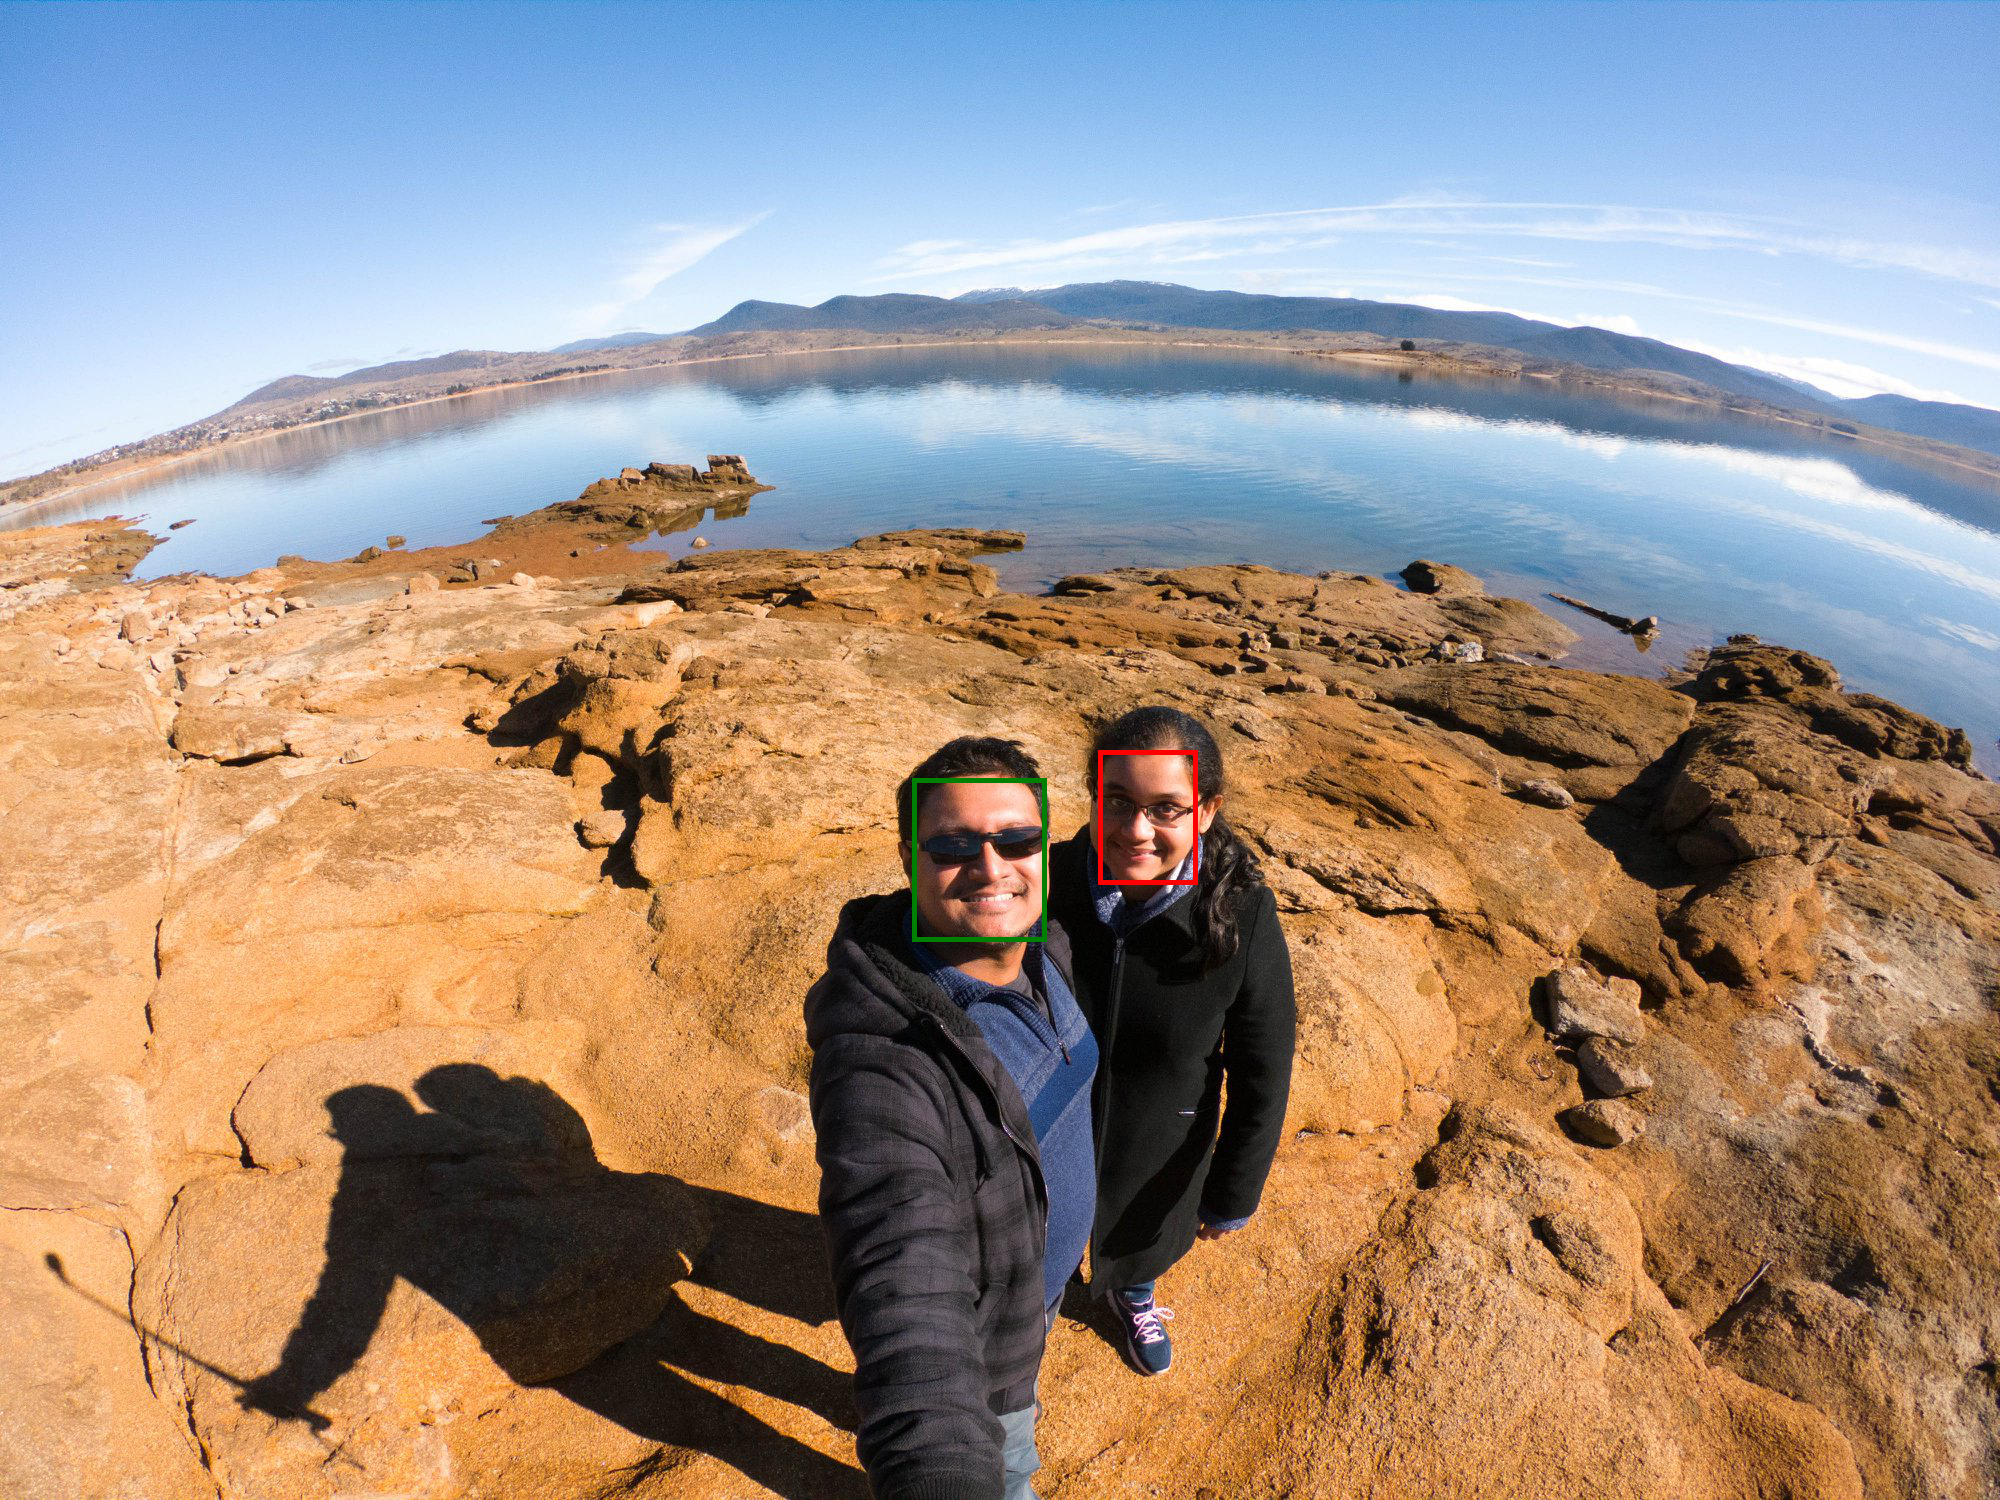

In [75]:
image_both_marked = Image.open(impath_both)
imagebb_both_marked = ImageDraw.Draw(image_both)

for is_me, (left, top, right, bottom) in zip(is_me_flags, both_boxes_big):
    imagebb_both_marked = ImageDraw.Draw(image_both_marked)
    shape = [left, top, right, bottom]
    imagebb_both_marked.rectangle(shape, outline="green" if is_me else "red", width=5)

display(image_both_marked)

Me
	 [186.15909  123.398964 312.13098  280.6076  ]
Both
	 [ 909.0059   769.5585  1048.2461   942.13574]
	 [1091.4462   741.63367 1198.5635   884.95575]
Distances [0.5910728  0.93908185] 0.34800905


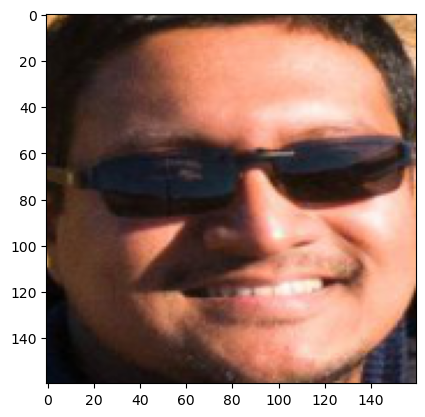

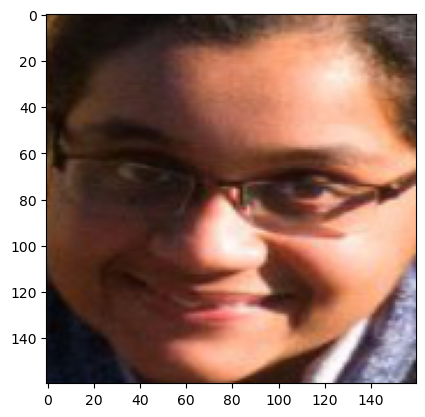

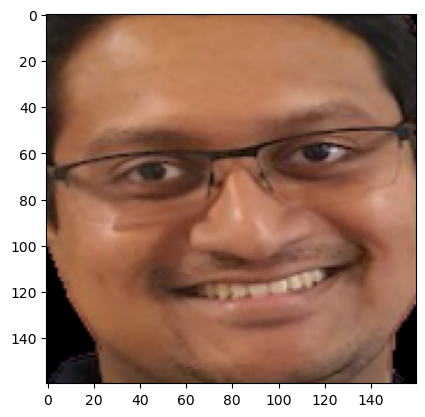

<Figure size 640x480 with 0 Axes>

In [76]:
def exp_noscaling(im_both, im_me):
    me_boxes = get_boxes(im_me)
    both_boxes = get_boxes(im_both)  
    
    print('Me')
    for b in me_boxes:
        print('\t', b)
    print('Both')
    for b in both_boxes:
        print('\t', b)
    me_faces = get_faces(im_me, me_boxes)
    both_faces = get_faces(im_both, both_boxes)
    
    e1 = get_encodings(me_faces)
    e2 = get_encodings(both_faces)
    
    distances = dist(e1, e2)
    print('Distances', distances, max(distances) - min(distances))
    
    for (left, top, right, bottom) in both_boxes:
        face = extract_face(im_both, (left, top, right, bottom))
        plt.imshow(face.permute(1, 2, 0).int().numpy())
        plt.figure()
    for (left, top, right, bottom) in me_boxes:
        face = extract_face(im_me, (left, top, right, bottom))
        plt.imshow(face.permute(1, 2, 0).int().numpy())
        plt.figure()
    
exp_noscaling(image_both_big, image_me_big)

## Embeddings from InceptionV2Resnet seems to be very helpful on new faces (probably due to colour difference, and deviation from original trainsets)